#  Multi-Period Portfolio Optimization with Transaction Costs

**GPU-Accelerated Quantitative Finance with cuProx**

This notebook demonstrates production-grade portfolio optimization:

- **Mean-Variance Optimization** (Markowitz QP)
- **Transaction costs** (linear and quadratic)
- **Position & turnover constraints**
- **Efficient frontier** visualization
- **Monte Carlo stress testing**
- **Performance benchmarks**

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import time
from dataclasses import dataclass
from typing import Optional
import sys
sys.path.insert(0, '../python')

import cuprox

# Dark theme for plots
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.family'] = 'monospace'

print(f"cuProx version: {cuprox.__version__}")
print(f"CUDA available: {cuprox.__cuda_available__}")

np.random.seed(42)

cuProx version: 0.1.0
CUDA available: True


## 1️⃣ Market Data Simulation

Generate realistic multi-factor returns with proper covariance structure:

In [2]:
def simulate_market(n_assets=30, n_days=504):
    """Generate realistic returns with factor structure."""
    n_factors = 5
    B = np.random.randn(n_assets, n_factors) * 0.3
    B[:, 0] = np.abs(B[:, 0]) + 0.5
    
    factor_vol = np.array([0.16, 0.08, 0.06, 0.05, 0.04]) / np.sqrt(252)
    factor_returns = np.random.randn(n_days, n_factors) * factor_vol
    
    idio_vol = np.random.uniform(0.15, 0.35, n_assets) / np.sqrt(252)
    idio_returns = np.random.randn(n_days, n_assets) * idio_vol
    
    alpha = np.random.uniform(-0.02, 0.08, n_assets) / 252
    returns = alpha + factor_returns @ B.T + idio_returns
    
    return returns, B, idio_vol

n_assets = 30
returns, factor_loadings, idio_vol = simulate_market(n_assets, 504)

mu = returns[-252:].mean(axis=0) * 252
cov = np.cov(returns[-252:].T) * 252

min_eig = np.linalg.eigvalsh(cov).min()
if min_eig < 1e-8:
    cov += np.eye(n_assets) * (1e-8 - min_eig)

print(f" Simulated {n_assets} assets over {len(returns)} days")
print(f"   Expected returns: {mu.min():.1%} to {mu.max():.1%}")
print(f"   Volatilities: {np.sqrt(np.diag(cov)).min():.1%} to {np.sqrt(np.diag(cov)).max():.1%}")
print(f"   Avg correlation: {(cov / np.outer(np.sqrt(np.diag(cov)), np.sqrt(np.diag(cov)))).mean():.2f}")

 Simulated 30 assets over 504 days
   Expected returns: -47.0% to 86.3%
   Volatilities: 18.3% to 36.3%
   Avg correlation: 0.23


## 2️⃣ Portfolio Optimizer (Mean-Variance QP)

In [3]:
@dataclass
class OptResult:
    weights: np.ndarray
    expected_return: float
    volatility: float
    sharpe: float
    turnover: float
    solve_time: float
    status: str
    iterations: int

class MeanVarianceOptimizer:
    def __init__(self, mu, cov, risk_aversion=1.0, tcost=0.001,
                 max_weight=0.10, max_turnover=0.30):
        self.n = len(mu)
        self.mu = mu
        self.cov = cov
        self.gamma = risk_aversion
        self.kappa = tcost
        self.w_max = max_weight
        self.tau_max = max_turnover
        
    def optimize(self, w_current=None):
        n = self.n
        if w_current is None:
            w_current = np.ones(n) / n
        
        P_blocks = [self.gamma * self.cov,
                    sparse.csr_matrix((n, n)),
                    sparse.csr_matrix((n, n))]
        P = sparse.block_diag(P_blocks, format='csr')
        
        q = np.concatenate([-self.mu,
                            self.kappa * np.ones(n),
                            self.kappa * np.ones(n)])
        
        rows, l_bounds, u_bounds = [], [], []
        
        budget_row = sparse.hstack([sparse.csr_matrix(np.ones((1,n))),
                                    sparse.csr_matrix((1,2*n))])
        rows.append(budget_row)
        l_bounds.append(1.0); u_bounds.append(1.0)
        
        trade_rows = sparse.hstack([sparse.eye(n), -sparse.eye(n), sparse.eye(n)])
        rows.append(trade_rows)
        l_bounds.extend(w_current.tolist())
        u_bounds.extend(w_current.tolist())
        
        turnover_row = sparse.hstack([sparse.csr_matrix((1,n)),
                                      sparse.csr_matrix(np.ones((1,n))),
                                      sparse.csr_matrix(np.ones((1,n)))])
        rows.append(turnover_row)
        l_bounds.append(0.0); u_bounds.append(self.tau_max)
        
        A = sparse.vstack(rows, format='csr')
        lb = np.concatenate([np.zeros(n), np.zeros(2*n)])
        ub = np.concatenate([np.full(n, self.w_max), np.full(2*n, 1.0)])
        
        start = time.perf_counter()
        result = cuprox.solve(
            c=q, A=A, b=np.zeros(len(l_bounds)), P=P,
            lb=lb, ub=ub,
            constraint_l=np.array(l_bounds),
            constraint_u=np.array(u_bounds),
            params={'tolerance': 1e-5, 'max_iterations': 10000}
        )
        solve_time = time.perf_counter() - start
        
        w = np.clip(result.x[:n], 0, self.w_max)
        w = w / w.sum() if w.sum() > 0 else np.ones(n)/n
        
        turnover = np.sum(result.x[n:2*n]) + np.sum(result.x[2*n:])
        port_ret = self.mu @ w
        port_vol = np.sqrt(w @ self.cov @ w)
        sharpe = port_ret / port_vol if port_vol > 0.01 else 0
        
        status = str(result.status.value) if hasattr(result.status, 'value') else str(result.status)
        
        return OptResult(weights=w, expected_return=port_ret, volatility=port_vol,
                        sharpe=sharpe, turnover=turnover, solve_time=solve_time,
                        status=status, iterations=result.iterations)

opt = MeanVarianceOptimizer(mu, cov, risk_aversion=2.0, max_weight=0.15)
res = opt.optimize()

print(f"\n Optimization Result:")
print(f"   Status: {res.status}")
print(f"   Expected Return: {res.expected_return:.2%}")
print(f"   Volatility: {res.volatility:.2%}")
print(f"   Sharpe Ratio: {res.sharpe:.2f}")
print(f"   Solve Time: {res.solve_time*1000:.1f}ms ({res.iterations} iters)")


 Optimization Result:
   Status: optimal
   Expected Return: 51.06%
   Volatility: 14.08%
   Sharpe Ratio: 3.63
   Solve Time: 369.9ms (25 iters)


## 3️⃣ Efficient Frontier

In [4]:
def compute_frontier(mu, cov, n_points=25):
    gammas = np.logspace(-1, 2, n_points)
    results = []
    
    print(f"Computing {n_points} frontier points...")
    start = time.perf_counter()
    
    for gamma in gammas:
        opt = MeanVarianceOptimizer(mu, cov, risk_aversion=gamma,
                                     max_weight=0.15, tcost=0.0)
        res = opt.optimize()
        if 'optimal' in res.status.lower():
            results.append({'gamma': gamma, 'return': res.expected_return,
                           'volatility': res.volatility, 'sharpe': res.sharpe,
                           'weights': res.weights, 'active': np.sum(res.weights > 0.01)})
    
    total = time.perf_counter() - start
    print(f" Completed {len(results)}/{n_points} in {total:.2f}s")
    return pd.DataFrame(results)

frontier = compute_frontier(mu, cov, 25)

if len(frontier) > 0:
    max_sharpe = frontier.loc[frontier['sharpe'].idxmax()]
    min_vol = frontier.loc[frontier['volatility'].idxmin()]
    print(f"\n Max Sharpe: {max_sharpe['sharpe']:.2f} (Ret: {max_sharpe['return']:.1%}, Vol: {max_sharpe['volatility']:.1%})")
    print(f" Min Vol: {min_vol['volatility']:.1%} (Ret: {min_vol['return']:.1%})")

Computing 25 frontier points...


 Completed 25/25 in 0.67s

 Max Sharpe: 3.93 (Ret: 53.5%, Vol: 13.6%)
 Min Vol: 12.2% (Ret: 44.8%)


/tmp/ipykernel_2302666/1779179887.py:44: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()


/tmp/ipykernel_2302666/1779179887.py:44: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_2302666/1779179887.py:44: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_2302666/1779179887.py:45: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('portfolio_frontier.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
/tmp/ipykernel_2302666/1779179887.py:45: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('portfolio_frontier.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
/tmp/ipykernel_2302666/1779179887.py:45: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('portfolio_frontier.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')


/home/beast/Desktop/cuprox/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/beast/Desktop/cuprox/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/beast/Desktop/cuprox/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


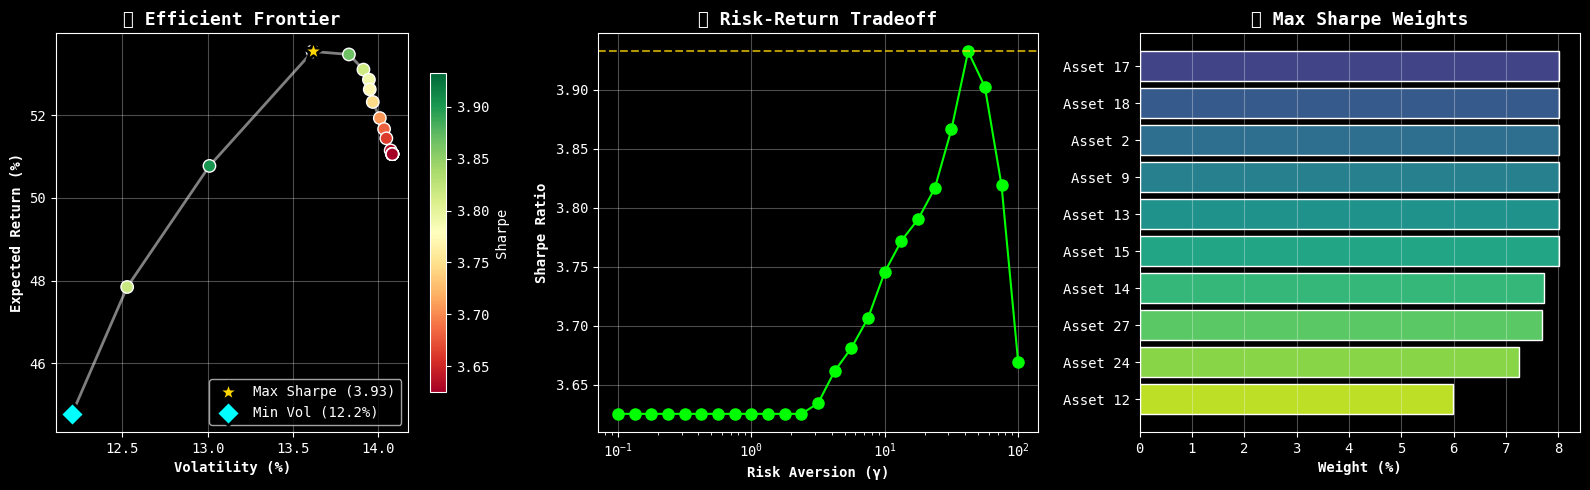

In [5]:
if len(frontier) > 3:
    fig = plt.figure(figsize=(16, 5))
    frontier_sorted = frontier.sort_values('volatility')
    
    ax1 = fig.add_subplot(131)
    sc = ax1.scatter(frontier_sorted['volatility']*100, frontier_sorted['return']*100,
                     c=frontier_sorted['sharpe'], cmap='RdYlGn', s=80,
                     edgecolors='white', linewidth=1, zorder=3)
    ax1.plot(frontier_sorted['volatility']*100, frontier_sorted['return']*100,
             'w-', alpha=0.5, linewidth=2, zorder=2)
    ax1.scatter(max_sharpe['volatility']*100, max_sharpe['return']*100,
                s=250, marker='*', c='gold', edgecolors='black', linewidth=2, zorder=5,
                label=f"Max Sharpe ({max_sharpe['sharpe']:.2f})")
    ax1.scatter(min_vol['volatility']*100, min_vol['return']*100,
                s=150, marker='D', c='cyan', edgecolors='black', linewidth=2, zorder=5,
                label=f"Min Vol ({min_vol['volatility']:.1%})")
    ax1.set_xlabel('Volatility (%)', fontweight='bold')
    ax1.set_ylabel('Expected Return (%)', fontweight='bold')
    ax1.set_title('📈 Efficient Frontier', fontsize=13, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    plt.colorbar(sc, ax=ax1, label='Sharpe', shrink=0.8)
    
    ax2 = fig.add_subplot(132)
    ax2.semilogx(frontier['gamma'], frontier['sharpe'], 'o-', color='lime', markersize=8)
    ax2.axhline(max_sharpe['sharpe'], color='gold', linestyle='--', alpha=0.7)
    ax2.set_xlabel('Risk Aversion (γ)', fontweight='bold')
    ax2.set_ylabel('Sharpe Ratio', fontweight='bold')
    ax2.set_title('🎯 Risk-Return Tradeoff', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    ax3 = fig.add_subplot(133)
    weights = max_sharpe['weights']
    sorted_idx = np.argsort(weights)[::-1][:10]
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, 10))
    ax3.barh(range(10), weights[sorted_idx]*100, color=colors, edgecolor='white')
    ax3.set_yticks(range(10))
    ax3.set_yticklabels([f'Asset {i+1}' for i in sorted_idx])
    ax3.set_xlabel('Weight (%)', fontweight='bold')
    ax3.set_title(' Max Sharpe Weights', fontsize=13, fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('portfolio_frontier.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
    plt.show()

## 4️⃣ Monte Carlo Stress Testing

In [6]:
def stress_test(mu, cov, base_weights, n_scenarios=100):
    n = len(mu)
    results = {'sharpe': [], 'volatility': [], 'return': [],
               'turnover': [], 'time': [], 'optimal': []}
    
    print(f" Running {n_scenarios} stress scenarios...")
    start_total = time.perf_counter()
    
    for i in range(n_scenarios):
        mu_shock = mu + np.random.randn(n) * 0.02
        vol_scale = 1 + 0.3 * np.abs(np.random.randn())
        cov_shock = cov * vol_scale
        
        opt = MeanVarianceOptimizer(mu_shock, cov_shock, risk_aversion=2.0,
                                     max_weight=0.15, max_turnover=0.30)
        res = opt.optimize(base_weights)
        
        results['sharpe'].append(res.sharpe)
        results['volatility'].append(res.volatility)
        results['return'].append(res.expected_return)
        results['turnover'].append(res.turnover)
        results['time'].append(res.solve_time)
        results['optimal'].append('optimal' in res.status.lower())
        
        if (i+1) % 25 == 0:
            print(f"   {i+1}/{n_scenarios} completed")
    
    total_time = time.perf_counter() - start_total
    n_opt = sum(results['optimal'])
    print(f"\n Complete: {total_time:.1f}s, {n_opt}/{n_scenarios} optimal")
    return {k: np.array(v) for k, v in results.items()}

base_weights = max_sharpe['weights'] if len(frontier) > 0 else np.ones(n_assets)/n_assets
stress = stress_test(mu, cov, base_weights, 100)

🔬 Running 100 stress scenarios...


   25/100 completed


   50/100 completed


   75/100 completed


   100/100 completed

 Complete: 2.1s, 100/100 optimal


/tmp/ipykernel_2302666/939987498.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_2302666/939987498.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_2302666/939987498.py:36: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_2302666/939987498.py:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('portfolio_stress_test.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
/tmp/ipykernel_2302666/939987498.py:37: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('portfolio_stress_test.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
/tmp/ipykernel_2302666/939987498.py:37: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND

/home/beast/Desktop/cuprox/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/beast/Desktop/cuprox/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


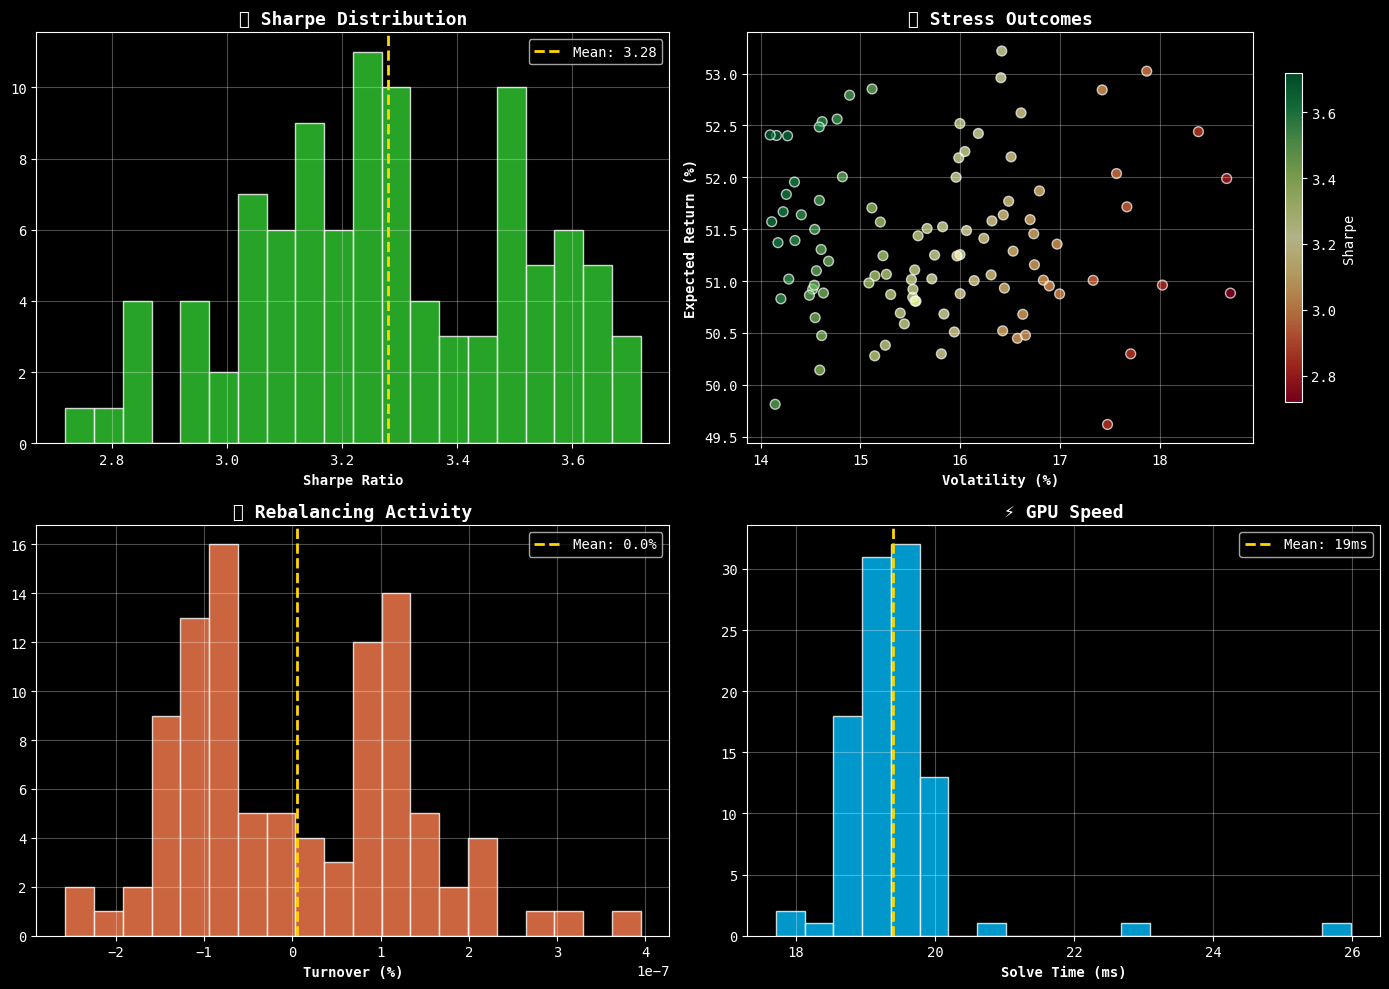

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
ax.hist(stress['sharpe'], bins=20, color='limegreen', edgecolor='white', alpha=0.8)
ax.axvline(np.mean(stress['sharpe']), color='gold', linestyle='--', linewidth=2,
           label=f"Mean: {np.mean(stress['sharpe']):.2f}")
ax.set_xlabel('Sharpe Ratio', fontweight='bold')
ax.set_title(' Sharpe Distribution', fontsize=13, fontweight='bold')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[0, 1]
sc = ax.scatter(stress['volatility']*100, stress['return']*100,
                c=stress['sharpe'], cmap='RdYlGn', s=50, alpha=0.7, edgecolors='white')
ax.set_xlabel('Volatility (%)', fontweight='bold')
ax.set_ylabel('Expected Return (%)', fontweight='bold')
ax.set_title(' Stress Outcomes', fontsize=13, fontweight='bold')
plt.colorbar(sc, ax=ax, label='Sharpe', shrink=0.8)
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
ax.hist(stress['turnover']*100, bins=20, color='coral', edgecolor='white', alpha=0.8)
ax.axvline(np.mean(stress['turnover'])*100, color='gold', linestyle='--', linewidth=2,
           label=f"Mean: {np.mean(stress['turnover'])*100:.1f}%")
ax.set_xlabel('Turnover (%)', fontweight='bold')
ax.set_title(' Rebalancing Activity', fontsize=13, fontweight='bold')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.hist(stress['time']*1000, bins=20, color='deepskyblue', edgecolor='white', alpha=0.8)
ax.axvline(np.mean(stress['time'])*1000, color='gold', linestyle='--', linewidth=2,
           label=f"Mean: {np.mean(stress['time'])*1000:.0f}ms")
ax.set_xlabel('Solve Time (ms)', fontweight='bold')
ax.set_title('⚡ GPU Speed', fontsize=13, fontweight='bold')
ax.legend(); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('portfolio_stress_test.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()

## 5️⃣ Performance Benchmarks

In [8]:
def benchmark_portfolio(n_assets_list=[10, 20, 30, 50], n_trials=20):
    results = []
    print("⚡ Running benchmarks...")
    
    for n in n_assets_list:
        np.random.seed(42)
        mu_b = np.random.randn(n) * 0.10
        cov_b = np.eye(n) * 0.04 + np.random.randn(n, n) * 0.01
        cov_b = (cov_b + cov_b.T) / 2 + np.eye(n) * 0.01
        
        opt = MeanVarianceOptimizer(mu_b, cov_b, risk_aversion=2.0, max_weight=min(0.20, 3/n))
        opt.optimize()  # warmup
        
        times = []
        for _ in range(n_trials):
            res = opt.optimize()
            if 'optimal' in res.status.lower():
                times.append(res.solve_time)
        
        if times:
            mean_ms = np.mean(times) * 1000
            results.append({'n_assets': n, 'mean_ms': mean_ms, 'std_ms': np.std(times)*1000,
                           'throughput': 1000/mean_ms})
            print(f"   {n:3d} assets: {mean_ms:6.1f}ms ({1000/mean_ms:.1f}/s)")
    
    return pd.DataFrame(results)

bench = benchmark_portfolio([10, 20, 30, 50], 20)

⚡ Running benchmarks...


    10 assets:   13.3ms (74.9/s)


    20 assets:   20.7ms (48.3/s)


    30 assets:   32.0ms (31.2/s)


    50 assets:   55.4ms (18.1/s)


/tmp/ipykernel_2302666/1427679925.py:27: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_2302666/1427679925.py:27: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_2302666/1427679925.py:27: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_2302666/1427679925.py:28: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('portfolio_benchmark.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
/tmp/ipykernel_2302666/1427679925.py:28: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('portfolio_benchmark.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
/tmp/ipykernel_2302666/1427679925.py:28: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans Mono.
  plt.sav

/home/beast/Desktop/cuprox/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/beast/Desktop/cuprox/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/beast/Desktop/cuprox/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


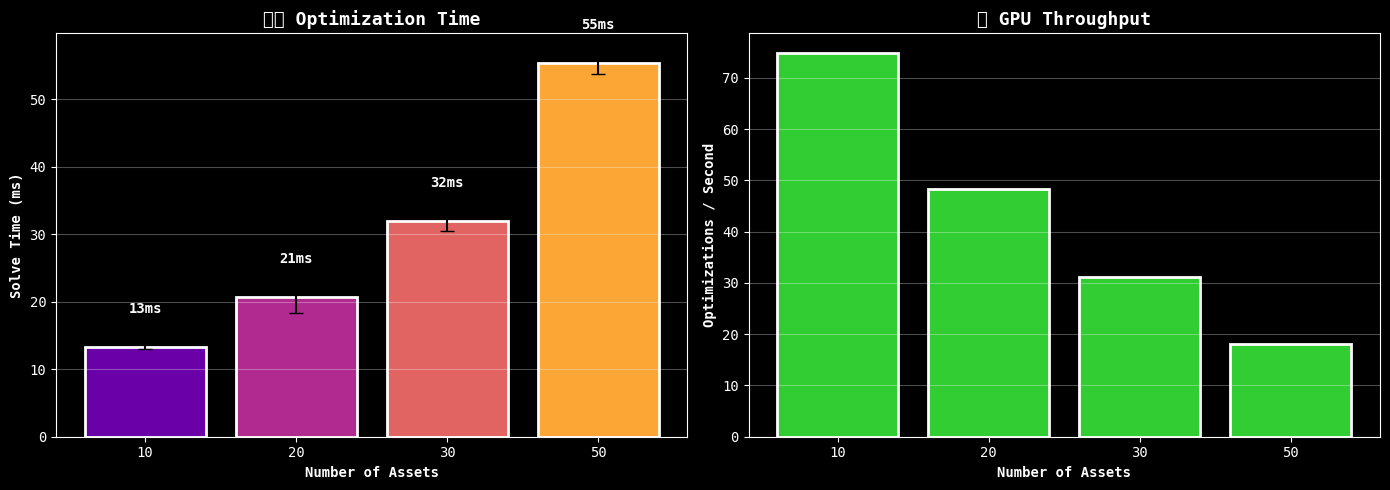

In [9]:
if len(bench) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax = axes[0]
    colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(bench)))
    bars = ax.bar(range(len(bench)), bench['mean_ms'], yerr=bench['std_ms'],
                  capsize=5, color=colors, edgecolor='white', linewidth=2)
    ax.set_xticks(range(len(bench)))
    ax.set_xticklabels([f"{n}" for n in bench['n_assets']])
    ax.set_xlabel('Number of Assets', fontweight='bold')
    ax.set_ylabel('Solve Time (ms)', fontweight='bold')
    ax.set_title('⏱️ Optimization Time', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    for bar, t in zip(bars, bench['mean_ms']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{t:.0f}ms', ha='center', fontweight='bold')
    
    ax = axes[1]
    ax.bar(range(len(bench)), bench['throughput'], color='limegreen', edgecolor='white', linewidth=2)
    ax.set_xticks(range(len(bench)))
    ax.set_xticklabels([f"{n}" for n in bench['n_assets']])
    ax.set_xlabel('Number of Assets', fontweight='bold')
    ax.set_ylabel('Optimizations / Second', fontweight='bold')
    ax.set_title('🚀 GPU Throughput', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('portfolio_benchmark.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
    plt.show()

## 📋 Summary

In [10]:
print("="*60)
print("  MULTI-PERIOD PORTFOLIO OPTIMIZATION COMPLETE")
print("="*60)
print(f"\ncuProx {cuprox.__version__} | GPU: {cuprox.__cuda_available__}")

if len(frontier) > 0:
    print(f"\n📈 Efficient Frontier: {len(frontier)} points")
    print(f"   Max Sharpe: {max_sharpe['sharpe']:.2f} (Ret: {max_sharpe['return']:.1%}, Vol: {max_sharpe['volatility']:.1%})")

print(f"\n🔬 Stress Test: {len(stress['sharpe'])} scenarios")
print(f"   Sharpe: {np.mean(stress['sharpe']):.2f} ± {np.std(stress['sharpe']):.2f}")

if len(bench) > 0:
    print(f"\n⚡ Peak Throughput: {bench['throughput'].max():.1f} optimizations/sec")

  MULTI-PERIOD PORTFOLIO OPTIMIZATION COMPLETE

cuProx 0.1.0 | GPU: True

📈 Efficient Frontier: 25 points
   Max Sharpe: 3.93 (Ret: 53.5%, Vol: 13.6%)

🔬 Stress Test: 100 scenarios
   Sharpe: 3.28 ± 0.23

⚡ Peak Throughput: 74.9 optimizations/sec
